推荐系统实战-3
=============
隐语义模型实战
------------

使用 [Text8](http://mattmahoney.net/dc/textdata) 数据集训练word2vec

1.安装依赖库

In [1]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
print('check：libs well prepared')

check：libs well prepared


2.下载数据并解压

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  #判断文件是否存在
  if not os.path.exists(filename):
    #下载
    print('download...')
    filename, _ = urlretrieve(url + filename, filename)
  #校验大小
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print('exception %s' % statinfo.st_size)
  return filename

filename = maybe_download('text8.zip', 31344016)

download...
Found and verified text8.zip


In [3]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


3.编码并替换低频次

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  #每个词出现的次数
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  #单词到数字的映射
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0 
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  #数字到单词的映射
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

#映射之后的训练数据
# data 是 word index
# count 是 [word，count]
# dictionary：与reverse_dictionary 键值对 相反
# reverse_dictionary 是<index,word>，index = data
data, count, dictionary, reverse_dictionary = build_dataset(words)

print('Most common words (+UNK)', count[:5])
print('original data', words[:10])
print('training data', data[:10])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
original data ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
training data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


4.生成skip-gram训练数据

In [6]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  # x y
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # context word context
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    # 循环使用
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # 
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])
# 得到训练数据
# 
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    batch: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']
    labels: ['a', 'anarchism', 'term', 'as', 'a', 'abuse', 'first', 'abuse']


5.定义网络结构

In [7]:
batch_size = 128
embedding_size = 128 # 
skip_window = 1 # 
num_skips = 2 # 
valid_size = 16 # 
valid_window = 100 #
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 #

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 输入数据
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # 定义变量
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  #本次训练数据对应的embedding
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # batch loss
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
  #优化loss，更新参数
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  #归一化
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  #用已有embedding计算valid的相似次
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


6.运行训练流程

In [8]:
num_steps = 100000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  average_loss = 0
  for step in range(num_steps+1):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    #2000次打印loss
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # 打印valid效果
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 #相似度最高的5个词
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 7.564521
Nearest to from: spain, freeh, perihelion, adriaan, hubble,
Nearest to that: balliol, necrosis, eldridge, awkward, aglaulus,
Nearest to up: overdose, sympathy, irritation, honolulu, prophylaxis,
Nearest to most: balm, fermions, oddie, danorum, artist,
Nearest to no: albertosaurus, deemed, mpaa, sourceforge, plea,
Nearest to the: ascension, geosynchronous, shaykh, aloof, belonging,
Nearest to they: fugazi, asa, frankenheimer, classifying, weighted,
Nearest to UNK: inquire, nationalists, fretless, allan, yoshi,
Nearest to used: talkie, directors, purely, blackbeard, nonempty,
Nearest to into: merit, itinerant, homophony, bridgewater, hybrids,
Nearest to these: carrel, sins, burg, deactivated, systematized,
Nearest to this: indianapolis, thru, crankshaft, ussr, jeannie,
Nearest to state: offline, dodgers, repeatedly, fermilab, appellant,
Nearest to see: concourse, elam, miners, dyer, stuart,
Nearest to during: tot, e, designers, ramesh, watering,
Nearest t

Average loss at step 72000: 3.381698
Average loss at step 74000: 3.346117
Average loss at step 76000: 3.316063
Average loss at step 78000: 3.348492
Average loss at step 80000: 3.379578
Nearest to from: through, into, across, during, modi,
Nearest to that: which, however, what, hyllus, this,
Nearest to up: off, out, them, down, him,
Nearest to most: many, more, some, less, multiplan,
Nearest to no: any, little, technologically, mpaa, deemed,
Nearest to the: a, its, each, their, this,
Nearest to they: we, he, there, you, she,
Nearest to UNK: williams, l, ko, gage, midlands,
Nearest to used: known, seen, described, written, found,
Nearest to into: through, within, from, over, neurotransmitter,
Nearest to these: many, several, such, some, both,
Nearest to this: which, it, the, that, there,
Nearest to state: states, city, harpo, meters, brythonic,
Nearest to see: include, encloses, references, list, but,
Nearest to during: after, in, until, when, despite,
Nearest to over: around, between, t

7.可视化

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

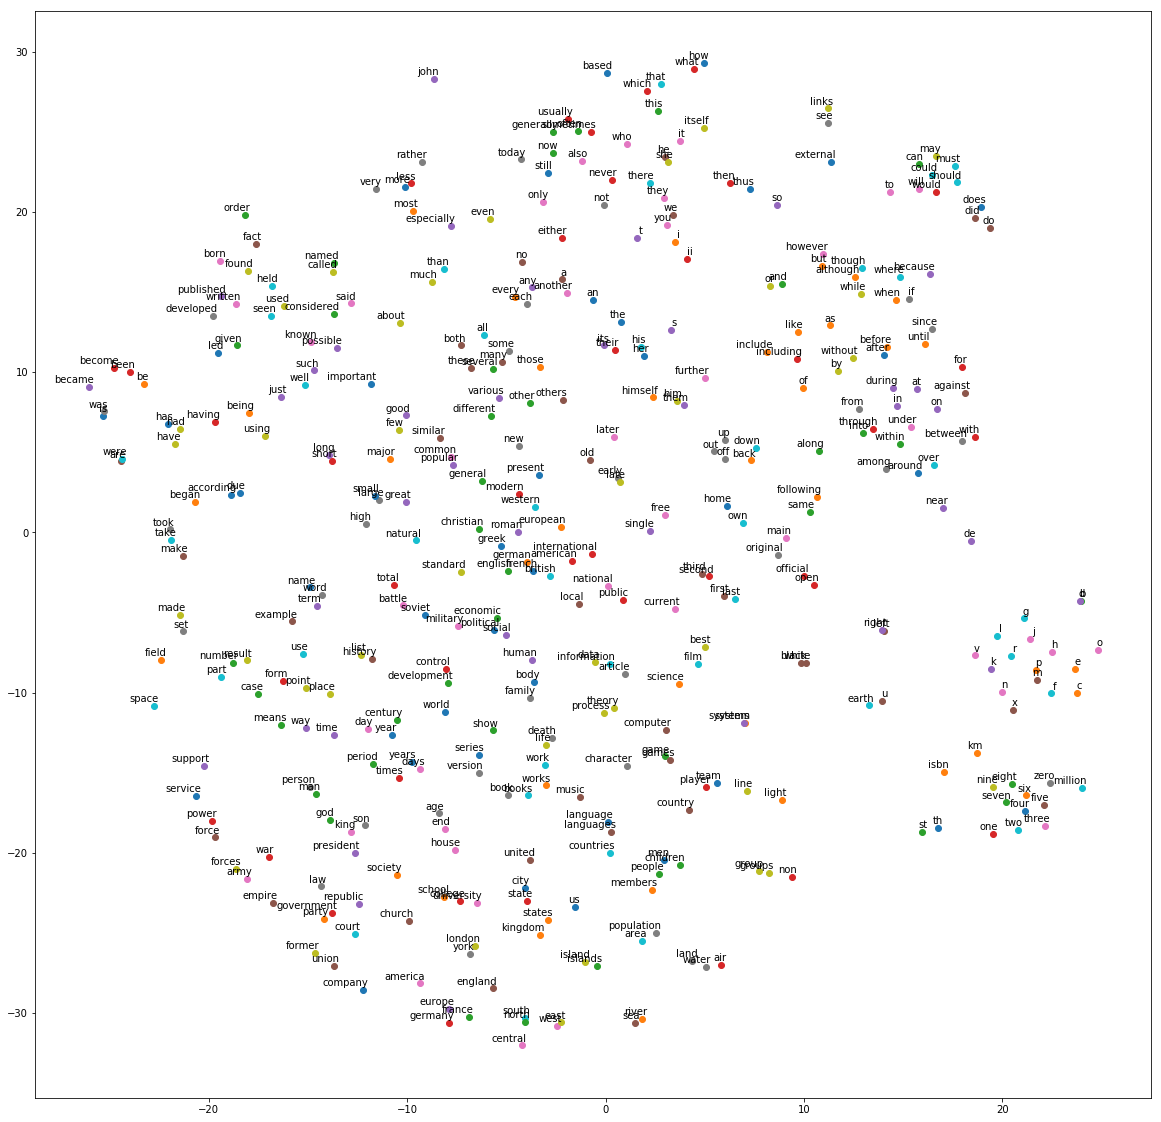

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)